<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Survival-value-of-gene-modules" data-toc-modified-id="Survival-value-of-gene-modules-5">Survival value of gene modules</a></span><ul class="toc-item"><li><span><a href="#Univariable-model" data-toc-modified-id="Univariable-model-5.1">Univariable model</a></span></li><li><span><a href="#TableS7" data-toc-modified-id="TableS7-5.2">TableS7</a></span></li></ul></li><li><span><a href="#Determine-module-membership-for-GES" data-toc-modified-id="Determine-module-membership-for-GES-6">Determine module membership for GES</a></span><ul class="toc-item"><li><span><a href="#Table-S8" data-toc-modified-id="Table-S8-6.1">Table S8</a></span></li><li><span><a href="#Quick-survival-analysis-using-important-genes" data-toc-modified-id="Quick-survival-analysis-using-important-genes-6.2">Quick survival analysis using important genes</a></span></li><li><span><a href="#Multivariable-model" data-toc-modified-id="Multivariable-model-6.3">Multivariable model</a></span></li></ul></li></ul></div>

# Dependencies

In [1]:
library(survival)
library(survminer)
library(forestplot)

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: grid

Loading required package: magrittr

Loading required package: checkmate



# Functions


In [2]:
forest.fx <- function(cox_matrix, mytitle, signumber, totalnumber){
    myhrs <- cox_matrix[,c(2,6,7)]
    myhrs <- rbind(NA, myhrs)
    mytabletext <- as.data.frame(cox_matrix[,c(2,5,8)])
    mytabletext <- format(round(mytabletext, 3))
    mytabletext <- cbind(rownames(mytabletext),mytabletext)
    colnames(mytabletext) <- c("Signature", "Hazard Ratio", "p-value", "FDR")
    rownames(mytabletext) <- NULL
    mytabletext <- rbind(colnames(mytabletext), mytabletext)
    
    fn <- local({
        i = 0
        nonsig <- totalnumber - signumber
        b_clrs = c(rep("red", signumber), rep("black",nonsig))
        l_clrs = c(rep("red", signumber), rep("black",nonsig))
        function(..., clr.line, clr.marker){
            i <<- i + 1
            fpDrawNormalCI(..., clr.line = l_clrs[i], clr.marker = b_clrs[i])
        }
    })
    
    fplot <- forestplot(mytabletext, fn.ci_norm = fn, myhrs,
                        new_page = TRUE, xlog = TRUE,
                        title = mytitle, boxsize = 0.3)

    return(fplot)
}

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INDICATE/Plots/"

# Main

In [4]:
gene_module_th <- read.csv(file = paste0(datapath, "WGCNA/TH/gene_module_treehouse_manual_signed_20.csv"),
                                      header = T, stringsAsFactors = F,row.names = 1,check.names = F) 

In [5]:
gene_module_th <- gene_module_th[ gene_module_th$moduleColor != "grey",]
gene_module_th$moduleLabel <- paste0("TH_", gene_module_th$moduleLabel)

In [6]:
tail(gene_module_th)

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
ZWINT,TH_4,yellow,ENSG00000122952.16,ENSG00000122952,11130
ZXDA,TH_6,red,ENSG00000198205.6,ENSG00000198205,7789
ZXDB,TH_17,grey60,ENSG00000198455.4,ENSG00000198455,158586
ZXDC,TH_6,red,ENSG00000070476.14,ENSG00000070476,79364
ZYG11B,TH_17,grey60,ENSG00000162378.12,ENSG00000162378,79699
ZZZ3,TH_6,red,ENSG00000036549.12,ENSG00000036549,26009


In [7]:
table(gene_module_th$moduleColor)


        black         brown          cyan     darkgreen      darkgrey 
          332           228            85            44            33 
   darkorange darkturquoise        grey60    lightgreen           red 
           28            43           535            51          1162 
       salmon       skyblue         white        yellow 
           58            24            28           393 

In [8]:
length(unique(gene_module_th$moduleColor))

[1] 14

In [9]:
nrow(gene_module_th)

[1] 3044

In [10]:
GO_modules <- read.csv(file.path(datapath,"WGCNA/TH/GO_TH_cons_manual_signed_20.csv"),
                       header = T, stringsAsFactors = F, check.names = F, row.names = 1)  

In [11]:
GO_modules <- GO_modules[ GO_modules$module != "grey",]

In [12]:
GO_modules$moduleLabel <- gene_module_th$moduleLabel[match(GO_modules$module, gene_module_th$moduleColor)]

In [13]:
# Add one MF for TH_28 module
TH28_MF <- GO_modules[ GO_modules$termName == "transcription regulator activity",]

In [14]:
GO_modules <- GO_modules[GO_modules$termOntology == "BP",]

In [15]:
GO_modules <- rbind(GO_modules, TH28_MF)

In [16]:
dim(GO_modules)

[1] 96  8

In [17]:
GO_modules <- GO_modules[ GO_modules$nModGenesInTerm >= 9,]

In [18]:
dim(GO_modules)

[1] 85  8

In [19]:
GO_modules$myterm <- NA

for(i in unique(GO_modules$moduleLabel)){
    tmp <- GO_modules[ GO_modules$moduleLabel == i,]
    moduleterm <- tmp$termName[tmp$nModGenesInTerm == min(tmp$nModGenesInTerm)][1] #use one term if min returns two terms
    GO_modules$myterm[GO_modules$moduleLabel == i] <- moduleterm
    
}

In [20]:
head(GO_modules)

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName,moduleLabel,myterm
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
GO:0016050,black,331,4.6e-13,8.5e-09,31,BP,vesicle organization,TH_7,vesicle organization
GO:0010256,black,331,9.7e-12,1.8e-07,34,BP,endomembrane system organization,TH_7,vesicle organization
GO:0042886,black,331,3.1e-11,5.8e-07,80,BP,amide transport,TH_7,vesicle organization
GO:0015031,black,331,3.2e-11,5.8e-07,78,BP,protein transport,TH_7,vesicle organization
GO:0046907,black,331,7.2e-11,1.3e-06,72,BP,intracellular transport,TH_7,vesicle organization
GO:0015833,black,331,8.7e-11,1.6e-06,78,BP,peptide transport,TH_7,vesicle organization


In [21]:
dim(gene_module_th)

[1] 3044    5

In [22]:
dim(GO_modules)

[1] 85  9

# Survival value of gene modules

In [23]:
metadata <- read.csv(file.path(datapath,"IND_estimate_metadata_IHC_trb_tmb.csv"),header = T, stringsAsFactors = F, 
                     check.names = F)

expression matrix in tpm hg38

added ensg ids. 

In [24]:
tpm_mat <- read.csv(file = paste0(datapath, "exp_mat/INDICATE.tpm_hg38_ENSG_HUGO.csv"), 
                    header = T, stringsAsFactors = F,check.names = F) 

In [25]:
dim(tpm_mat)

[1] 26475    75

In [26]:
tpm_mat[1:10,1:10]

,ensembl_id,HGNC_symbol,go29664_ngs_rna_targrna_rnaaccess_06520001b0023r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520003c0012r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520004c0018r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520005c0017r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520006c0016r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520007c0018r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520008c0017r_20171125.genes.results,go29664_ngs_rna_targrna_rnaaccess_06520010b0023r_20171125.genes.results
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000121410.11,A1BG,0.06,1.23,0.69,0.36,0.32,0.76,0.00,2.46
2,ENSG00000268895.5,A1BG-AS1,0.14,1.41,1.21,1.36,0.38,0.55,0.00,0.77
3,ENSG00000148584.14,A1CF,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,ENSG00000175899.14,A2M,114.92,98.31,50.73,30.12,35.55,384.47,212.23,71.93
5,ENSG00000245105.2,A2M-AS1,0.10,1.07,0.49,0.87,0.43,0.58,0.00,0.49
6,ENSG00000166535.19,A2ML1,0.00,0.00,0.00,0.04,0.02,0.00,0.00,3.73
7,ENSG00000256069.7,A2MP1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,ENSG00000184389.9,A3GALT2,0.10,0.00,0.02,0.02,0.00,0.02,0.00,0.00
9,ENSG00000128274.15,A4GALT,2.81,8.51,6.03,0.79,0.86,1.27,0.02,2.80


In [27]:
indicate_ids <- tpm_mat[,1:2]

Remove samples with no ensg id to compare with TH data and remove HGNC

In [28]:
tpm_mat_ensg <- tpm_mat[!is.na(tpm_mat$ensembl_id),]

In [29]:
dim(tpm_mat_ensg)

[1] 24447    75

remove hugos add ensembl ids as rownames

In [30]:
tpm_mat_ensg$HGNC_symbol <- NULL
rownames(tpm_mat_ensg) <- gsub("[.].*", "",tpm_mat_ensg$ensembl_id)
tpm_mat_ensg$ensembl_id <- NULL

In [31]:
dim(tpm_mat_ensg)

[1] 24447    73

transpose and clean up sample IDs

In [32]:
tpm_mat_ensg_t <- t(tpm_mat_ensg)

In [33]:
rownames(tpm_mat_ensg_t) <- gsub(".*rnaaccess_", "", rownames(tpm_mat_ensg_t))
rownames(tpm_mat_ensg_t) <- gsub("_.*", "", rownames(tpm_mat_ensg_t))
rownames(tpm_mat_ensg_t) <- toupper(rownames(tpm_mat_ensg_t))

log2 transform

In [34]:
tpm_mat_ensg_t <- log2(tpm_mat_ensg_t + 1)

In [35]:
dim(tpm_mat_ensg_t)

[1]    73 24447

match samples with those in metadata

In [36]:
tpm_mat_ensg_t_matched <- tpm_mat_ensg_t[rownames(tpm_mat_ensg_t) %in% metadata$sample_id,]

In [37]:
dim(tpm_mat_ensg_t_matched)

[1]    66 24447

module label cleanup

In [38]:
head(gene_module_th)

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
A2M,TH_22,darkgreen,ENSG00000175899.14,ENSG00000175899,2
AAK1,TH_7,black,ENSG00000115977.18,ENSG00000115977,22848
AASDH,TH_6,red,ENSG00000157426.13,ENSG00000157426,132949
AASDHPPT,TH_6,red,ENSG00000149313.10,ENSG00000149313,60496
ABCB10,TH_6,red,ENSG00000135776.4,ENSG00000135776,23456
ABCE1,TH_6,red,ENSG00000164163.10,ENSG00000164163,6059


In [39]:
dim(gene_module_th)

[1] 3044    5

In [40]:
mygene_modules <- gene_module_th[ gene_module_th$ensembl_id %in% colnames(tpm_mat_ensg_t_matched),]

In [41]:
#genes that were in imatrix data but not in treehouse
gene_module_th[!rownames(gene_module_th) %in% rownames(mygene_modules),]

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
BMS1P4,TH_6,red,ENSG00000242338.6,ENSG00000242338,NA
ECSCR,TH_22,darkgreen,ENSG00000249751.3,ENSG00000249751,641700
KAT6B,TH_6,red,ENSG00000156650.12,ENSG00000156650,23522
KIAA1143,TH_6,red,ENSG00000163807.5,ENSG00000163807,57456
KIF15,TH_4,yellow,ENSG00000163808.16,ENSG00000163808,56992
MATR3,TH_6,red,ENSG00000015479.17,ENSG00000015479,9782
RCC2,TH_4,yellow,ENSG00000179051.13,ENSG00000179051,55920
SLC16A1,TH_4,yellow,ENSG00000155380.11,ENSG00000155380,6566
ZKSCAN7,TH_6,red,ENSG00000196345.12,ENSG00000196345,55888


## Univariable model

Make a gene signature matrix for all samples

In [42]:
#Order same as heatmap
labelorders <- c('TH_4','TH_18','TH_17','TH_28','TH_6','TH_7','TH_14',
                 'TH_24','TH_23','TH_27','TH_3','TH_13','TH_22','TH_26')

In [43]:
module_sample <- matrix(ncol = nrow(tpm_mat_ensg_t_matched), nrow = length(unique(mygene_modules$moduleLabel)))
rownames(module_sample) <- labelorders
colnames(module_sample) <- rownames(tpm_mat_ensg_t_matched)

In [44]:
for(mod in 1:nrow(module_sample)){
    mymod <- rownames(module_sample)[mod]    
    modGenes <- mygene_modules$ensembl_id[which(mygene_modules$moduleLabel == mymod)]
    genes <- tpm_mat_ensg_t_matched[,modGenes]
if(length(modGenes) > 1){
    averagegenes <- apply(genes,1,mean)
    module_sample[mod,] <- averagegenes}
}

In [45]:
dim(module_sample)

[1] 14 66

Merge with metadata for survival analysis

In [46]:
module_sample_t <- as.data.frame(t(module_sample))
module_sample_t$sample_id <- rownames(module_sample_t)

In [47]:
metadata_modules <- merge(metadata, module_sample_t, by = "sample_id")

Run cox and make a summary matrix

In [48]:
module_cox <- matrix(nrow = nrow(module_sample), ncol = 7)
rownames(module_cox) <- rownames(module_sample)
colnames(module_cox) <- c('coef', 'exp(coef)', 'se(coef)', 'z', 'Pr(>|z|)', 'lower.95' ,'upper.95')

In [49]:
for(i in rownames(module_cox)){
   # message(i)
    f <- as.formula(paste0("Surv(TRTDUR, progressed)~", i))  
    coxmodel <- coxph(f, data=metadata_modules) 
    sumcox <- summary(coxmodel)
   # print(sumcox)
    module_cox[i,1:5] <- sumcox$coefficients[1,1:5]
    module_cox[i,6:7] <- sumcox$conf.int[1,3:4]
}

Calculate FDR add to matrix

In [50]:
fdr_df <- as.matrix(p.adjust(module_cox[,5], method = "fdr"))
colnames(fdr_df)[1] <- "fdr"
module_cox <- cbind(module_cox, fdr_df)

In [51]:
module_cox

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95,fdr
TH_4,0.26275994,1.3005145,0.2341486,1.12219311,0.261780341,0.8218784,2.0578932,0.61082080
TH_18,-0.04886734,0.9523075,0.2950671,-0.16561433,0.868460466,0.5340914,1.6980041,0.93526512
TH_17,-0.21641351,0.8054022,0.3312179,-0.65338721,0.513506685,0.4208038,1.5415086,0.68908419
TH_28,-0.17251042,0.8415495,0.2824973,-0.61066211,0.541423293,0.4837461,1.4640026,0.68908419
TH_6,-0.16634058,0.8467578,0.3421508,-0.48616163,0.626852576,0.4330319,1.6557642,0.73132800
TH_7,-0.29204773,0.7467329,0.3107780,-0.93973113,0.347355493,0.4060978,1.3730930,0.68908419
TH_14,-0.19463045,0.8231388,0.2841113,-0.68504997,0.493312389,0.4716687,1.4365114,0.68908419
TH_24,-0.01897856,0.9812004,0.2896798,-0.06551567,0.947763434,0.5561371,1.7311455,0.94776343
TH_23,0.14233871,1.1529671,0.1923932,0.73983248,0.459401648,0.7907725,1.6810563,0.68908419
TH_27,-0.33939059,0.7122042,0.1164899,-2.91347644,0.003574288,0.5668239,0.8948720,0.02087031


Make a manual list of module labels and go terms

In [52]:
module_cox <- as.data.frame(module_cox)

In [53]:
module_cox

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95,fdr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TH_4,0.26275994,1.3005145,0.2341486,1.12219311,0.261780341,0.8218784,2.0578932,0.61082080
TH_18,-0.04886734,0.9523075,0.2950671,-0.16561433,0.868460466,0.5340914,1.6980041,0.93526512
TH_17,-0.21641351,0.8054022,0.3312179,-0.65338721,0.513506685,0.4208038,1.5415086,0.68908419
TH_28,-0.17251042,0.8415495,0.2824973,-0.61066211,0.541423293,0.4837461,1.4640026,0.68908419
TH_6,-0.16634058,0.8467578,0.3421508,-0.48616163,0.626852576,0.4330319,1.6557642,0.73132800
TH_7,-0.29204773,0.7467329,0.3107780,-0.93973113,0.347355493,0.4060978,1.3730930,0.68908419
TH_14,-0.19463045,0.8231388,0.2841113,-0.68504997,0.493312389,0.4716687,1.4365114,0.68908419
TH_24,-0.01897856,0.9812004,0.2896798,-0.06551567,0.947763434,0.5561371,1.7311455,0.94776343
TH_23,0.14233871,1.1529671,0.1923932,0.73983248,0.459401648,0.7907725,1.6810563,0.68908419


In [54]:
module_cox$term <- NA

module_cox$term <- GO_modules$myterm[match(rownames(module_cox),GO_modules$moduleLabel)]

In [55]:
module_cox

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95,fdr,term
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
TH_4,0.26275994,1.3005145,0.2341486,1.12219311,0.261780341,0.8218784,2.0578932,0.61082080,DNA replication
TH_18,-0.04886734,0.9523075,0.2950671,-0.16561433,0.868460466,0.5340914,1.6980041,0.93526512,mRNA metabolic process
TH_17,-0.21641351,0.8054022,0.3312179,-0.65338721,0.513506685,0.4208038,1.5415086,0.68908419,cellular protein modification process
TH_28,-0.17251042,0.8415495,0.2824973,-0.61066211,0.541423293,0.4837461,1.4640026,0.68908419,transcription regulator activity
TH_6,-0.16634058,0.8467578,0.3421508,-0.48616163,0.626852576,0.4330319,1.6557642,0.73132800,RNA metabolic process
TH_7,-0.29204773,0.7467329,0.3107780,-0.93973113,0.347355493,0.4060978,1.3730930,0.68908419,vesicle organization
TH_14,-0.19463045,0.8231388,0.2841113,-0.68504997,0.493312389,0.4716687,1.4365114,0.68908419,cellular protein localization
TH_24,-0.01897856,0.9812004,0.2896798,-0.06551567,0.947763434,0.5561371,1.7311455,0.94776343,RNA splicing
TH_23,0.14233871,1.1529671,0.1923932,0.73983248,0.459401648,0.7907725,1.6810563,0.68908419,SRP-dependent cotranslational protein targeting to membrane


In [56]:
# some cleanup for terms

module_cox$term[module_cox$term == "antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent" ] <- 
"antigen processing and presentation"
module_cox$term[module_cox$term == "SRP-dependent cotranslational protein targeting to membrane" ] <- "protein targeting to ER"

## TableS7

In [57]:
xlsx::write.xlsx(module_cox, 
                 file = "~/OneDrive - UHN/Documents/Manuscripts/INDICATE/v2/TableS7.xlsx")

In [58]:
hrs <- module_cox[,c(2,6,7)]
hrs <- rbind(NA,hrs)

In [59]:
hrs

,exp(coef),lower.95,upper.95
,<dbl>,<dbl>,<dbl>
1,NA,NA,NA
TH_4,1.3005145,0.8218784,2.0578932
TH_18,0.9523075,0.5340914,1.6980041
TH_17,0.8054022,0.4208038,1.5415086
TH_28,0.8415495,0.4837461,1.4640026
TH_6,0.8467578,0.4330319,1.6557642
TH_7,0.7467329,0.4060978,1.3730930
TH_14,0.8231388,0.4716687,1.4365114
TH_24,0.9812004,0.5561371,1.7311455


In [60]:
tabtext <- as.data.frame(module_cox[,c(2,5,8)])
tabtext <- format(round(tabtext, 2))
tabtext <- cbind(module_cox[,9],tabtext)
colnames(tabtext) <- c("Signature", "Hazard Ratio", "p-value", "FDR")
rownames(tabtext) <- NULL
tabtext <- rbind(colnames(tabtext),tabtext)

In [61]:
tabtext

Signature,Hazard Ratio,p-value,FDR
<chr>,<I<chr>>,<I<chr>>,<I<chr>>
Signature,Hazard Ratio,p-value,FDR
DNA replication,1.30,0.26,0.61
mRNA metabolic process,0.95,0.87,0.94
cellular protein modification process,0.81,0.51,0.69
transcription regulator activity,0.84,0.54,0.69
RNA metabolic process,0.85,0.63,0.73
vesicle organization,0.75,0.35,0.69
cellular protein localization,0.82,0.49,0.69
RNA splicing,0.98,0.95,0.95


In [62]:
tabtext$`Hazard Ratio` <- NULL

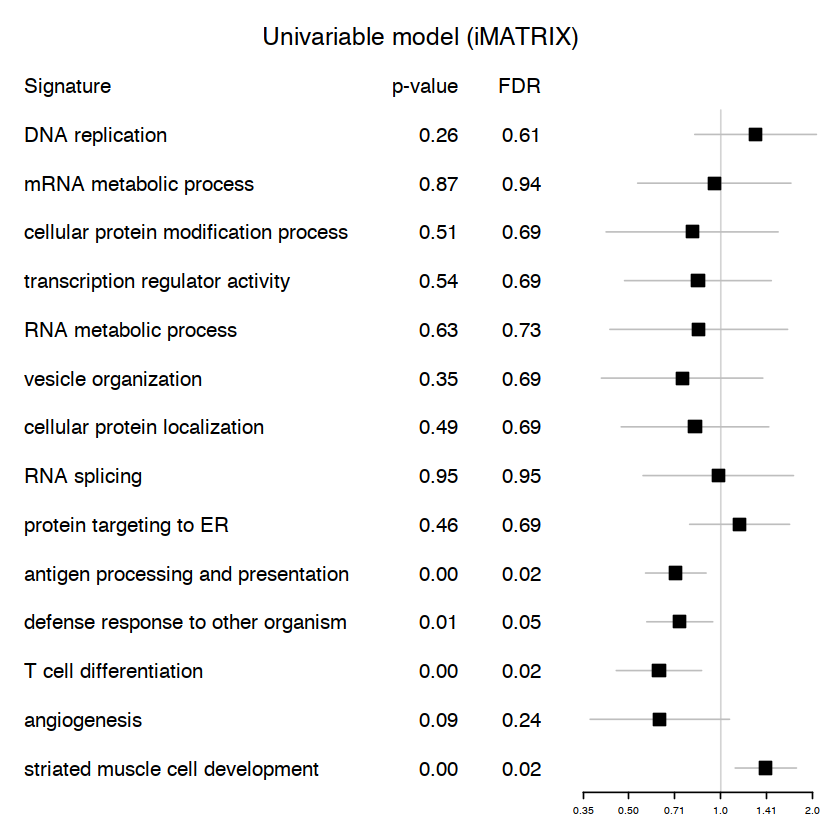

In [63]:
fplot <- forestplot(tabtext, hrs, new_page = TRUE, xlog = TRUE,
                   title = "Univariable model (iMATRIX)", boxsize = 0.25)

In [64]:
pdf(file = paste0(plotpath,"Univar_forestplot.pdf"),
    width = 7, height = 10,
    useDingbats = FALSE, onefile = F)

forestplot(tabtext, hrs, new_page = TRUE, xlog = TRUE,
                   title = "Univariable model (iMATRIX)", boxsize = 0.25)

dev.off()

pdf 
  2

# Determine module membership for GES

In [65]:
library(WGCNA)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [66]:
mountpath <- "/Users/anabbi/Desktop/H4H/INDICATE/wgcna/th/"

In [67]:
load(paste0(mountpath, "Consensus_Network_TH_manual_signed_20.RData"))

In [68]:
load(file = paste0(datapath, "WGCNA/TH/Consensus-dataInput_Treehouse_tpm.RData"))

In [69]:
gene_module <- read.csv(file = paste0(datapath, "/WGCNA/TH/gene_module_treehouse_manual_signed_20.csv"),
                       header = T, stringsAsFactors = F,row.names = 1,check.names = F) 

In [70]:
GO_module <- read.csv(file = paste0(datapath, "WGCNA/TH/GO_TH_cons_manual_signed_20.csv"),
                       header = T, stringsAsFactors = F,row.names = 1,check.names = F) 

In [71]:
head(GO_module)

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
GO:0000139,black,331,3.6e-14,6.6e-10,49,CC,Golgi membrane
GO:0005794,black,331,1.9e-13,3.5e-09,73,CC,Golgi apparatus
GO:0016050,black,331,4.6e-13,8.5e-09,31,BP,vesicle organization
GO:0031090,black,331,8.8e-13,1.6e-08,120,CC,organelle membrane
GO:0012505,black,331,4.0e-12,7.3e-08,140,CC,endomembrane system
GO:0010256,black,331,9.7e-12,1.8e-07,34,BP,endomembrane system organization


In [72]:
# add module labels to GO data
labels_colors <- gene_module[ !duplicated(gene_module$moduleColor),c("moduleLabel", "moduleColor")]
GO_module$label <- NA
for(i in 1:nrow(labels_colors)){
    mycolor <- labels_colors$moduleColor[i]
    GO_module$label[GO_module$module == mycolor] <- labels_colors$moduleLabel[labels_colors$moduleColor == mycolor]
    }

In [73]:
GO_module[ GO_module$label == 3,]

,module,modSize,enrichmentP,BonferoniP,nModGenesInTerm,termOntology,termName,label
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<int>
GO:0006955,brown,224,2.5e-99,4.5e-95,155,BP,immune response,3
GO:0002376,brown,224,1.7e-82,3.1e-78,164,BP,immune system process,3
GO:0002682,brown,224,2.0e-61,3.6e-57,112,BP,regulation of immune system process,3
GO:0001775,brown,224,2.9e-59,5.2e-55,107,BP,cell activation,3
GO:0006952,brown,224,3.6e-59,6.6e-55,111,BP,defense response,3
GO:0045321,brown,224,1.5e-58,2.7e-54,102,BP,leukocyte activation,3
GO:0050776,brown,224,1.5e-56,2.7e-52,88,BP,regulation of immune response,3
GO:0051707,brown,224,9.0e-46,1.7e-41,92,BP,response to other organism,3
GO:0043207,brown,224,1.0e-45,1.9e-41,92,BP,response to external biotic stimulus,3


In [74]:
modNames <- substring(names(consMEs[[1]]$data), 3)

In [75]:
length(consMEs)

[1] 7

In [76]:
geneInfo <- gene_module

In [77]:
for(c in 1:length(consMEs)){
    #for each cancer, correlate genes with module eigengenes
    geneModuleMembership <- as.data.frame(cor(treehouse_gene_mat[[c]]$data, consMEs[[c]]$data, use = "p"))
    MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples[c]))
    #add cancer index to colnames
    names(geneModuleMembership) <- paste0("MM_TH", modNames, "_", c)
    names(MMPvalue) <- paste0("p.MM_TH", modNames, "_", c)
    
    geneInfo <- data.frame(geneInfo, geneModuleMembership[rownames(geneInfo),],
                           MMPvalue[rownames(geneInfo), ])
}

In [78]:
geneInfo <- geneInfo[ geneInfo$moduleLabel != 0,]

In [79]:
geneInfo$moduleLabel <- as.character(geneInfo$moduleLabel)

## Table S8

In [80]:
tables8 <- geneInfo[, !grepl("TH0", colnames(geneInfo))]
tables8$moduleLabel <- paste0("TH_", tables8$moduleLabel)

In [ ]:
xlsx::write.xlsx(tables8, 
                 file = "~/OneDrive - UHN/Documents/Manuscripts/INDICATE/v2/TableS8.xlsx")

In [ ]:
#Antigen presentation module
TH_27 <- geneInfo[ geneInfo$moduleLabel == "27",]

In [ ]:
dim(TH_27)

In [ ]:
rownames(TH_27)

In [ ]:
TH_27[order(TH_27$MM_TH27_1, TH_27$MM_TH27_2, TH_27$MM_TH27_3, TH_27$MM_TH27_4,
            TH_27$MM_TH27_5, TH_27$MM_TH27_6,TH_27$MM_TH27_7),grepl("MM_TH27", colnames(TH_27))]

In [ ]:
mm27_1 <- rownames(TH_27)[TH_27$MM_TH27_1 > 0.8]
mm27_2 <- rownames(TH_27)[TH_27$MM_TH27_2 > 0.8]
mm27_3 <- rownames(TH_27)[TH_27$MM_TH27_3 > 0.8]
mm27_4 <- rownames(TH_27)[TH_27$MM_TH27_4 > 0.8]
mm27_5 <- rownames(TH_27)[TH_27$MM_TH27_5 > 0.8]
mm27_6 <- rownames(TH_27)[TH_27$MM_TH27_6 > 0.8]
mm27_7 <- rownames(TH_27)[TH_27$MM_TH27_7 > 0.8]

In [ ]:
Reduce(intersect, list(mm27_1, mm27_2, mm27_3 ,mm27_4,mm27_5,mm27_6,mm27_7))

In [ ]:
# T cell activation
TH_13 <- geneInfo[ geneInfo$moduleLabel == "13",]

In [ ]:
dim(TH_13)

In [ ]:
rownames(TH_13)

In [ ]:
TH_13[ order(TH_13$MM_TH13_1, TH_13$MM_TH13_2, TH_13$MM_TH13_3, TH_13$MM_TH13_4,
            TH_13$MM_TH13_5, TH_13$MM_TH13_6,TH_13$MM_TH13_7),grepl("MM_TH13", colnames(TH_13))]

In [ ]:
mm13_1 <- rownames(TH_13)[TH_13$MM_TH13_1 > 0.8]
mm13_2 <- rownames(TH_13)[TH_13$MM_TH13_2 > 0.8]
mm13_3 <- rownames(TH_13)[TH_13$MM_TH13_3 > 0.8]
mm13_4 <- rownames(TH_13)[TH_13$MM_TH13_4 > 0.8]
mm13_5 <- rownames(TH_13)[TH_13$MM_TH13_5 > 0.8]
mm13_6 <- rownames(TH_13)[TH_13$MM_TH13_6 > 0.8]
mm13_7 <- rownames(TH_13)[TH_13$MM_TH13_7 > 0.8]

In [ ]:
Reduce(intersect, list(mm13_1, mm13_2, mm13_3 ,mm13_4,mm13_5,mm13_6,mm13_7))

In [ ]:
# Muscle dev
TH_26 <- geneInfo[ geneInfo$moduleLabel == "26",]

In [ ]:
rownames(TH_26)

In [ ]:
dim(TH_26)

In [ ]:
TH_26[ order(TH_26$MM_TH26_1, TH_26$MM_TH26_2, TH_26$MM_TH26_3, TH_26$MM_TH26_4,
            TH_26$MM_TH26_5, TH_26$MM_TH26_6,TH_26$MM_TH26_7),grepl("MM_TH26", colnames(TH_26))]

In [99]:
mm26_1 <- rownames(TH_26)[TH_26$MM_TH26_1 > 0.8]
mm26_2 <- rownames(TH_26)[TH_26$MM_TH26_2 > 0.8]
mm26_3 <- rownames(TH_26)[TH_26$MM_TH26_3 > 0.8]
mm26_4 <- rownames(TH_26)[TH_26$MM_TH26_4 > 0.8]
mm26_5 <- rownames(TH_26)[TH_26$MM_TH26_5 > 0.8]
mm26_6 <- rownames(TH_26)[TH_26$MM_TH26_6 > 0.8]
mm26_7 <- rownames(TH_26)[TH_26$MM_TH26_7 > 0.8]

In [100]:
Reduce(intersect, list(mm26_1, mm26_2,mm26_3,mm26_4,mm26_5,mm26_6,mm26_7))

[1] "KLHL41"

In [101]:
# Just over 5% FDR - immune response module
TH_3 <- geneInfo[ geneInfo$moduleLabel == "3",]

In [102]:
mm3_1 <- rownames(TH_3)[TH_3$MM_TH3_1 > 0.8]
mm3_2 <- rownames(TH_3)[TH_3$MM_TH3_2 > 0.8]
mm3_3 <- rownames(TH_3)[TH_3$MM_TH3_3 > 0.8]
mm3_4 <- rownames(TH_3)[TH_3$MM_TH3_4 > 0.8]
mm3_5 <- rownames(TH_3)[TH_3$MM_TH3_5 > 0.8]
mm3_6 <- rownames(TH_3)[TH_3$MM_TH3_6 > 0.8]
mm3_7 <- rownames(TH_3)[TH_3$MM_TH3_7 > 0.8]

In [104]:
Reduce(intersect, list(mm3_1, mm3_2, mm3_3 ,mm3_4,mm3_5,mm3_6,mm3_7))

[1] "C3AR1"   "CCR5"    "CLEC7A"  "CTSS"    "IL12RB1" "ITGAM"   "LRRC25" 
 [8] "MNDA"    "SAMSN1"  "SIGLEC7" "SIGLEC9" "SNX20"   "TLR8"

## Quick survival analysis using important genes

In [105]:
module_sample <- matrix(ncol = nrow(tpm_mat_ensg_t_matched), nrow = 3)
rownames(module_sample) <- c("TH_13", "TH_26", "TH_27")
colnames(module_sample) <- rownames(tpm_mat_ensg_t_matched)

In [106]:
head(module_sample)

,06520001B0023R,06520003C0012R,06520004C0018R,06520005C0017R,06520006C0016R,06520007C0018R,06520008C0017R,06520010B0023R,06520011B0023R,06520015C0016R,⋯,06520095B0017R,06520097B0021R,06520099B0017R,06520100B0017R,06520103C0017R,06520104C0017R,06520105C0017R,06520106C0017R,06520107C0017R,06520110C0016R
TH_13,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TH_26,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
TH_27,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [107]:
head(mygene_modules)

,moduleLabel,moduleColor,ensembl_id_TH,ensembl_id,entrez
,<chr>,<chr>,<chr>,<chr>,<int>
A2M,TH_22,darkgreen,ENSG00000175899.14,ENSG00000175899,2
AAK1,TH_7,black,ENSG00000115977.18,ENSG00000115977,22848
AASDH,TH_6,red,ENSG00000157426.13,ENSG00000157426,132949
AASDHPPT,TH_6,red,ENSG00000149313.10,ENSG00000149313,60496
ABCB10,TH_6,red,ENSG00000135776.4,ENSG00000135776,23456
ABCE1,TH_6,red,ENSG00000164163.10,ENSG00000164163,6059


In [108]:
mygen <- mygene_modules$ensembl_id[ rownames(mygene_modules) %in% "KLHL41"]
genes <- tpm_mat_ensg_t_matched[,mygen]

In [109]:
module_sample["TH_26",] <- genes

In [110]:
mygen <- mygene_modules$ensembl_id[ rownames(mygene_modules) %in% c('CD2','CD3D','CD3E','CD3G','CXCR3','THEMIS','UBASH3A')]
genes <- tpm_mat_ensg_t_matched[,mygen]

In [111]:
averagegenes <- apply(genes,1,mean)

In [112]:
module_sample["TH_13",] <- averagegenes

In [113]:
module_samplemygen <- mygene_modules$ensembl_id[ rownames(mygene_modules) %in% c('HLA-B','HLA-F','PSMB9')]

genes <- tpm_mat_ensg_t_matched[,mygen]

averagegenes <- apply(genes,1,mean)

module_sample["TH_27",] <- averagegenes

In [114]:
module_sample

,06520001B0023R,06520003C0012R,06520004C0018R,06520005C0017R,06520006C0016R,06520007C0018R,06520008C0017R,06520010B0023R,06520011B0023R,06520015C0016R,⋯,06520095B0017R,06520097B0021R,06520099B0017R,06520100B0017R,06520103C0017R,06520104C0017R,06520105C0017R,06520106C0017R,06520107C0017R,06520110C0016R
TH_13,0.8034742,4.9275058,4.0912993,0.08551532,0.5531959,1.9188268,0.03585165,0.6275425,0.2252948,1.603264,⋯,0.7298162,2.26694873,5.3403622,3.2737386,2.3460847,4.3566979,0.7259099,0.4494325,1.596793,1.620667
TH_26,1.5704629,0.1375035,0.2265085,4.44095220,6.4929748,0.5160151,0.50589093,0.3448285,0.6322682,3.992768,⋯,2.1795111,0.02856915,0.3785116,0.6690268,0.3895668,0.2630344,1.7355222,0.5655972,2.090853,1.226509
TH_27,0.8034742,4.9275058,4.0912993,0.08551532,0.5531959,1.9188268,0.03585165,0.6275425,0.2252948,1.603264,⋯,0.7298162,2.26694873,5.3403622,3.2737386,2.3460847,4.3566979,0.7259099,0.4494325,1.596793,1.620667


Merge with metadata for survival analysis

In [115]:
module_sample_t <- as.data.frame(t(module_sample))
module_sample_t$sample_id <- rownames(module_sample_t)

In [116]:
metadata_modules <- merge(metadata, module_sample_t, by = "sample_id")

In [118]:
f <- as.formula(paste0("Surv(TRTDUR, progressed)~", "TH_13"))  
    coxmodel <- coxph(f, data=metadata_modules) 
summary(coxmodel)

Call:
coxph(formula = f, data = metadata_modules)

  n= 60, number of events= 49 
   (6 observations deleted due to missingness)

         coef exp(coef) se(coef)      z Pr(>|z|)   
TH_13 -0.3264    0.7215   0.1092 -2.988   0.0028 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

      exp(coef) exp(-coef) lower .95 upper .95
TH_13    0.7215      1.386    0.5825    0.8938

Concordance= 0.671  (se = 0.044 )
Likelihood ratio test= 10.94  on 1 df,   p=9e-04
Wald test            = 8.93  on 1 df,   p=0.003
Score (logrank) test = 9.64  on 1 df,   p=0.002


## Multivariable model

Make a gene signature matrix for all samples

In [119]:
module_sample <- matrix(ncol = nrow(tpm_mat_ensg_t_matched), nrow = length(unique(mygene_modules$moduleLabel)))
rownames(module_sample) <- labelorders
colnames(module_sample) <- rownames(tpm_mat_ensg_t_matched)

In [120]:
for(mod in 1:nrow(module_sample)){
    mymod <- rownames(module_sample)[mod]    
    modGenes <- mygene_modules$ensembl_id[which(mygene_modules$moduleLabel == mymod)]
    genes <- tpm_mat_ensg_t_matched[,modGenes]
if(length(modGenes) > 1){
    averagegenes <- apply(genes,1,mean)
    module_sample[mod,] <- averagegenes}
}

In [121]:
head(module_sample)

,06520001B0023R,06520003C0012R,06520004C0018R,06520005C0017R,06520006C0016R,06520007C0018R,06520008C0017R,06520010B0023R,06520011B0023R,06520015C0016R,⋯,06520095B0017R,06520097B0021R,06520099B0017R,06520100B0017R,06520103C0017R,06520104C0017R,06520105C0017R,06520106C0017R,06520107C0017R,06520110C0016R
TH_4,3.258641,2.543560,2.470124,3.873546,2.379499,2.629001,3.626413,3.324695,3.378651,3.010907,⋯,2.951200,3.083745,2.632355,2.061169,3.220097,3.715501,3.701069,3.795182,3.725360,2.996888
TH_18,3.402986,3.732832,3.247667,4.139311,3.341334,3.291128,4.050459,3.721943,3.655911,3.816681,⋯,3.551753,3.175228,3.525619,3.196350,3.502437,3.907429,4.421255,4.021101,4.220187,3.828690
TH_17,2.899621,3.349528,2.850904,2.935903,2.614786,2.895317,3.348928,3.045980,2.964719,3.480863,⋯,3.015086,2.616543,3.032016,2.728924,3.155685,3.335919,3.722357,3.176780,3.500666,3.466325
TH_28,2.122054,2.508796,2.143300,3.314616,2.165245,1.977253,2.165512,2.499301,2.533448,3.328631,⋯,2.511312,1.076290,2.442948,2.083394,2.147661,2.551371,3.625210,2.598789,3.111280,2.757612
TH_6,2.835558,3.165800,2.741455,3.255378,2.731744,2.760267,3.137937,3.093191,3.024381,3.281667,⋯,3.015380,2.593224,2.971578,2.649060,2.974029,3.278718,3.668864,3.268602,3.505263,3.297834
TH_7,3.246414,3.515224,3.084530,3.041327,2.726420,3.288073,3.286074,3.328865,3.101268,3.797706,⋯,3.225476,2.599680,3.158812,3.012368,3.441499,3.529465,3.870514,3.326879,3.653408,3.721464


Merge with metadata for survival analysis

In [122]:
module_sample_t <- as.data.frame(t(module_sample))
module_sample_t$sample_id <- rownames(module_sample_t)

In [123]:
metadata_modules <- merge(metadata, module_sample_t, by = "sample_id")

Run cox and make a summary matrix

In [124]:
module_cox <- matrix(nrow = nrow(module_sample), ncol = 7)
rownames(module_cox) <- rownames(module_sample)
colnames(module_cox) <- c('coef', 'exp(coef)', 'se(coef)', 'z', 'Pr(>|z|)', 'lower.95' ,'upper.95')

In [125]:
for(i in rownames(module_cox)){
  #  message(i)
    f <- as.formula(paste0("Surv(TRTDUR, progressed)~", i, " + sample_origin"))  
    coxmodel <- coxph(f, data=metadata_modules) 
    sumcox <- summary(coxmodel)
   # print(sumcox)
    module_cox[i,1:5] <- sumcox$coefficients[1,1:5]
    module_cox[i,6:7] <- sumcox$conf.int[1,3:4]
}

In [126]:
head(module_cox)

,coef,exp(coef),se(coef),z,Pr(>|z|),lower.95,upper.95
TH_4,0.1258451,1.1341065,0.2626941,0.4790558,0.63189891,0.6777168,1.897839
TH_18,-0.3245838,0.7228281,0.3048519,-1.0647265,0.28699972,0.3976900,1.313788
TH_17,-0.4159244,0.6597301,0.3508369,-1.1855206,0.23581166,0.3316907,1.312198
TH_28,-0.5627951,0.5696147,0.3163769,-1.7788756,0.07526015,0.3063943,1.058965
TH_6,-0.4413447,0.6431710,0.3597122,-1.2269385,0.21984571,0.3177890,1.301709
TH_7,-0.4939272,0.6102252,0.3346354,-1.4760160,0.13993959,0.3166999,1.175797


Calculate FDR add to matrix

In [127]:
fdr_df <- as.matrix(p.adjust(module_cox[,5], method = "fdr"))
colnames(fdr_df)[1] <- "fdr"
module_cox <- cbind(module_cox, fdr_df)

Order FDR for plot

In [128]:
module_cox <- module_cox[order(module_cox[,8], module_cox[,2]),]

GRID.VP.7::forestplot_margins 

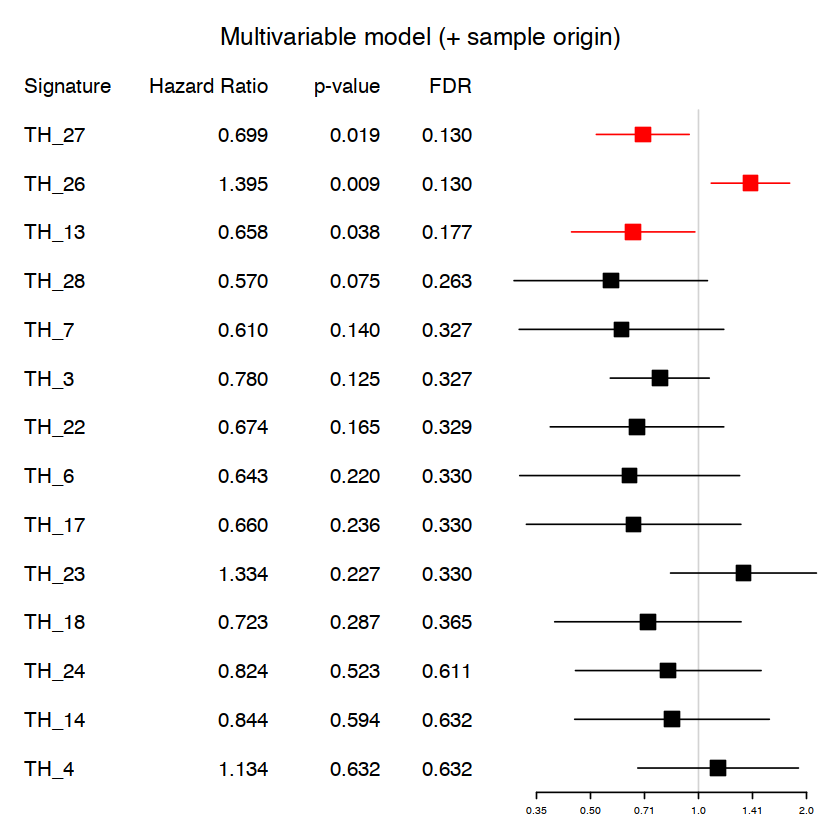

In [131]:
forest.fx(module_cox, "Multivariable model (+ sample origin)", 3, 14)

In [132]:
pdf(file = paste0(plotpath,"Multivar_forestplot_ordered.pdf"),
    width = 8, height = 12,
    useDingbats = FALSE, onefile = F)

forest.fx(module_cox, "Multivariable model (sample origin)", 3, 14)

dev.off()

GRID.VP.9::forestplot_margins 

pdf 
  2